In [1]:
import pandas as pd, ipywidgets as widgets, numpy as np, matplotlib.pyplot as plt, io
raw_uploader, eln_uploader = widgets.FileUpload(multiple = False), widgets.FileUpload(multiple = False)
assay_type_widget = widgets.Text(placeholder='Type something',description='Assay Type:', disabled=False)
display("Upload ELN w/ Functional Data and Antibodies Sheet (xlsx), and specify assay type")
display(eln_uploader)
display(assay_type_widget)

'Upload ELN w/ Functional Data and Antibodies Sheet (xlsx), and specify assay type'

FileUpload(value={}, description='Upload')

Text(value='', description='Assay Type:', placeholder='Type something')

In [2]:
elnname = list(eln_uploader.value.keys())[0]
eln = pd.read_excel(io.BytesIO(eln_uploader.value[elnname]['content']))
ab_sheet = pd.read_excel(io.BytesIO(eln_uploader.value[elnname]['content']), sheet_name = "Antibody Plate Map")
functional_assay_type = assay_type_widget.value

agonist_data = pd.read_excel(io.BytesIO(eln_uploader.value[elnname]['content']), sheet_name = functional_assay_type + " Agonist")
antagonist_data = pd.read_excel(io.BytesIO(eln_uploader.value[elnname]['content']), sheet_name = functional_assay_type + " Antagonist")

In [3]:
#Function that ensures a given antibody platemap is formatted correctly (by columns, not rows)
#Mutable function that changes the antibody sheet indicated by ab_sheet
#ie A1->B1-->H1->A2-->B2-->A12-->H12
#First, separate the Well ID into separate "Plate Number","Format Row" and "Format Column" values 
#(Row is Letter, Column is Number)
#Sort the platemap into proper Plate -> Column -> Row format
#Returns nothing, mutates the ab_sheet antibody plate map
def format_platemap():
    ab_sheet["Format Row"] = ab_sheet["Well ID"].str.slice(start = 0, stop = 1)
    numeric_col = ab_sheet["Well ID"].str.slice(start = 1)
    numeric_col = pd.to_numeric(numeric_col)
    ab_sheet["Format Column"] = numeric_col
    ab_sheet.sort_values(by=["Plate Number","Format Column", "Format Row"], inplace=True, ignore_index = True)
    return

#Average function that takes a series with n=1, n=2 replicates in sequential order within the series, and 
#Separates n=1 and n=2 replicates resets indeces, and calculates average
#Returns a series with the averaged values, removing the replicate wells
def average(series_to_average):
    firsts = series_to_average.iloc[::2]
    seconds = series_to_average.iloc[1::2]
    firsts.reset_index(inplace = True, drop = True)
    seconds.reset_index(inplace = True, drop = True)
    averaged_series = firsts + seconds
    averaged_series = averaged_series/2
    return averaged_series

#Takes a Pandas dataframe as an input. Takes every column from the dataframe and concatenates them into one single series
#Returns the new series that has all of the data in one column, starting from 1st column -> max # of columns
def columnize(df_to_columnize):
    return_column = pd.Series()
    for column in df_to_columnize.columns:
        colToAdd = df_to_columnize[column]
        return_column = pd.concat([return_column, colToAdd], axis = 0, ignore_index = True)
    return return_column


#Flow binding functions for iQue3 data

# #Return cleaned iQue3 data with only samples of the well type specified
# def clean_for_well_type(well_type_string):
#     return data_cleaned[data_cleaned["Well Type"] == well_type_string]

# #Average function that takes a string indicating the well type of interest (marked in iQue3 software, or manually changed in csv)
# #Also takes a string indicating the data from the csv to be averaged (to_average_string)
# #Separates n=1 and n=2 replicates from 384 well format, resets indeces, and averages
# #Returns a series with the averaged MFI ratios, removing the replicate wells
# def average(well_type_string, to_average_string):
#     selected_wells = clean_for_well_type(well_type_string)
#     values_to_average = selected_wells[to_average_string]
#     return average(values_to_average)

# #Calculates the MFI ratio given a positive and negative series, 
# #and appends the MFI ratio to the original data frame, excluding the negative population
# #Calculates the average cell count for each duplicate, and appends average cell count to original data frame
# def calculate_analysis_sheet(positive, negative):
#     MFI_ratio = positive/negative
#     original_positive = clean_for_well_type("Positive")
#     original_positive = original_positive[::2]
#     original_positive.reset_index(inplace = True, drop = True)
#     original_positive["MFI Ratio"] = MFI_ratio
#     MFIs_Antibody = pd.concat([original_positive, ab_sheet], axis = 1)
#     MFIs_Antibody.index += 1
#     averagePositiveCounts = average("Positive", "Count of singlets")
#     return MFIs_Antibody[["Plate", "Well ID", "Well Type", "MFI Ratio", "DNA", "Format Row", "Format Column"]] 


In [4]:
#Create new DF for concatenating the Agonist, Antagonist signals, and the Antibody Plate Map
format_platemap()

agonist_column, antagonist_column = columnize(agonist_data), columnize(antagonist_data)
averageAgonists, averageAntagonists = average(agonist_column), average(antagonist_column)
OutputSheet = pd.concat([averageAgonists, averageAntagonists, ab_sheet], axis = 1)
OutputSheet.index += 1
OutputSheet.rename(inplace = True, columns = {0: "Agonist Mode", 1: "Antagonist Mode"})
OutputSheetCleaned = OutputSheet[["Agonist Mode", "Antagonist Mode", "DNA", "Concentration (mg/mL)"]]
OutputSheetCleaned.to_excel(functional_assay_type + " Functional Assay Agonist and Antagonist Mode Analysis.xlsx", sheet_name = 'Analyzed Data')
AgonistSort = OutputSheetCleaned.sort_values(by="Agonist Mode", ascending = False)
AgonistSort
#AntagonistSort = OutputSheetCleaned.sort_values(by="Antagonist Mode", ascending = False)
#OutputSheet

/var/folders/k8/mg372j_55z30k1z4y_8mb0w00000gn/T/ipykernel_50947/3984694805.py:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return_column = pd.Series()
/var/folders/k8/mg372j_55z30k1z4y_8mb0w00000gn/T/ipykernel_50947/3984694805.py:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return_column = pd.Series()


Agonist Mode  Antagonist Mode             DNA  Concentration (mg/mL)
40       2.568789         2.170519       TB620-156                 0.0600
80       2.559384         1.767111       TB620-023                 0.3700
31       2.427802         1.232292       TB620-140                 0.2100
52       2.289987         1.787956       TB620-040                 0.0100
104      1.871268         3.070330       TB620-012                 0.5480
..            ...              ...             ...                    ...
4        0.681640         1.331259       TB620-171                 0.0000
59       0.638277         1.751052       TB620-089                 0.0100
113           NaN              NaN  Tmab_220423_TN                 1.1169
114           NaN              NaN  Tmab_220423_TN                 1.0964
115           NaN              NaN  Tmab_220423_TN                 1.3160

[115 rows x 4 columns]

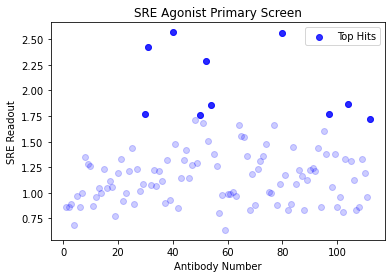

In [5]:
TopLeads = OutputSheetCleaned.nlargest(10, "Agonist Mode")
fig, ax = plt.subplots()
ax.scatter(x = OutputSheetCleaned.index, y=OutputSheetCleaned["Agonist Mode"], alpha = .2, color = "blue")
ax.scatter(x = TopLeads.index, y = TopLeads["Agonist Mode"], alpha = .8, color = "blue", label = "Top Hits")
ax.set_title(functional_assay_type + " Agonist Primary Screen")
ax.set_xlabel("Antibody Number")
ax.set_ylabel(functional_assay_type + " Readout")
ax.legend()
